# ✨ Linear Regression ✨
Linear regression is a type of supervised machine learning algorithm that computes the linear relationship between the dependent variable and one or more independent features by fitting a linear equation to observed data.

# Contents:

### Implement Linear Regression model using numpy, PyTorch and sklearn


In [36]:
from IPython.display import clear_output

!pip install dask[dataframe] catboost

clear_output()

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import zipfile
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Data
https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

> We are going to use the `Student Performance` dataset. Since Student Performance is a continuous variable, this is a regression problem. The data contains the following columns:

Variables:

*   Hours Studied: The total number of hours spent studying by each student.
* Previous Scores: The scores obtained by students in previous tests.
* Extracurricular Activities: Whether the student participates in extracurricular activities (Yes or No).
* Sleep Hours: The average number of hours of sleep the student had per day.
* Sample Question Papers Practiced: The number of sample question papers the student practiced.

Target Variable:
* Performance Index: A measure of the overall performance of each student.



In [12]:
# Download latest version
path = kagglehub.dataset_download("nikhil7280/student-performance-multiple-linear-regression")

print("Path to dataset files:", path)

csv_path = os.path.join(path, "Student_Performance.csv")

SP = pd.read_csv(csv_path)
SP.head()

Path to dataset files: /root/.cache/kagglehub/datasets/nikhil7280/student-performance-multiple-linear-regression/versions/1


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


# EDA 📊

In [13]:
SP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [14]:
SP.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [15]:
SP.describe(exclude="number")

,Extracurricular Activities
count,10000
unique,2
top,No
freq,5052


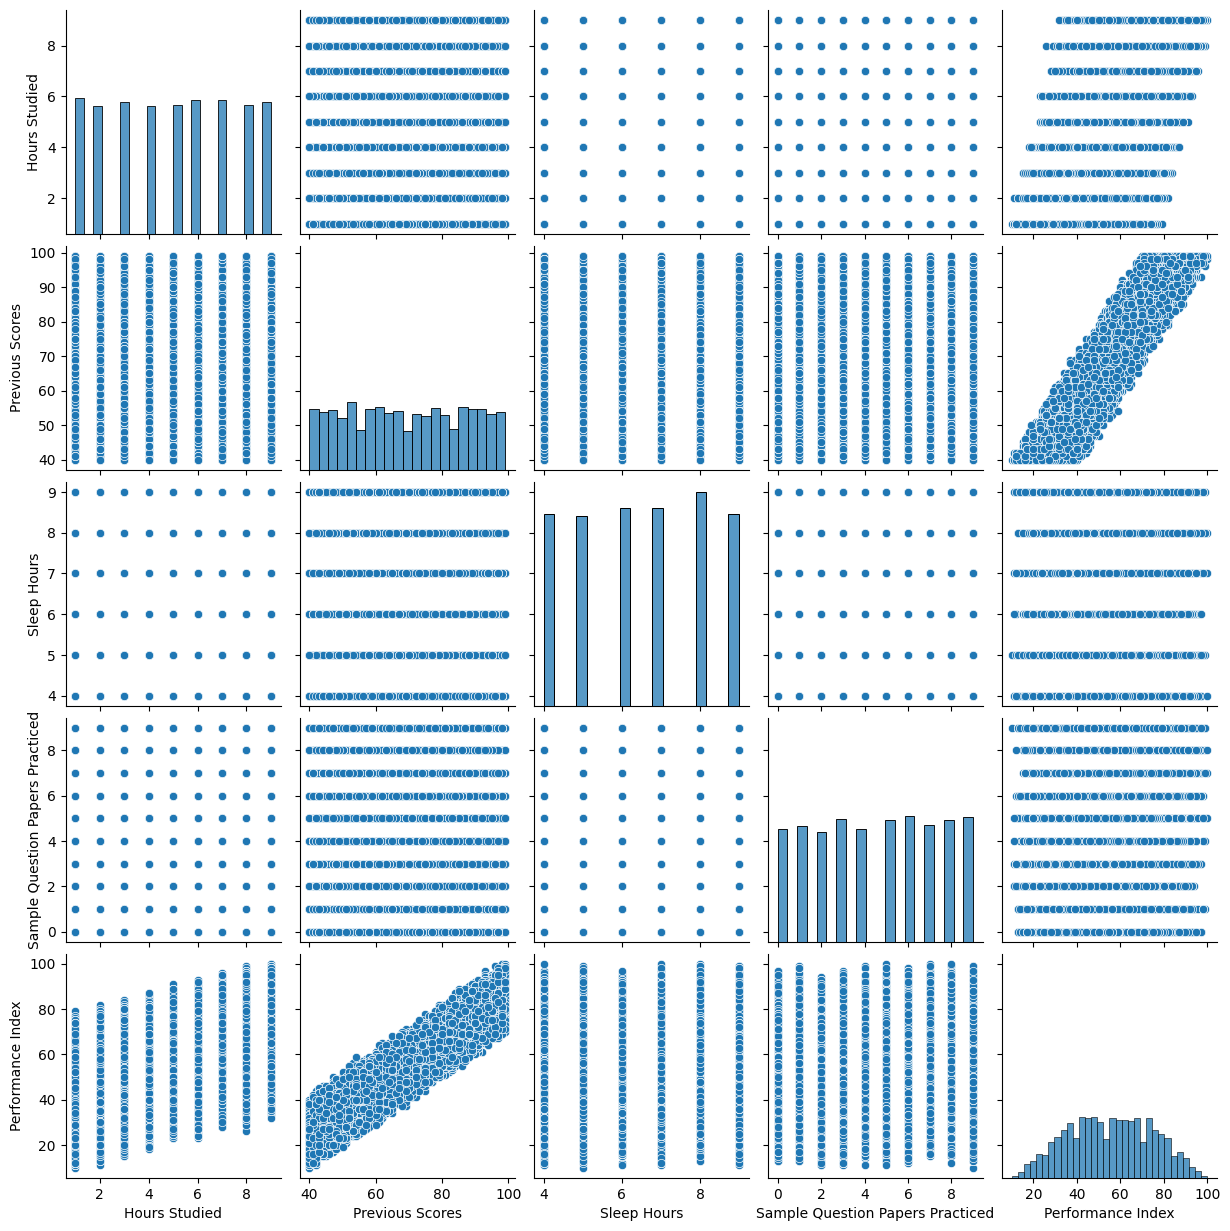

In [17]:
sns.pairplot(SP)

* Notice that the relationship between "Performance Index" and "Pervious Scores" shows a clear positive correlation: higher Pervious Scores tends to be associated with higher Performance Index.
* Also, the scatter plots between "Sleep Hours" and other variables show horizontal/vertical stripes, suggesting this variable is categorical or has fixed values (discrete).

<Axes: >

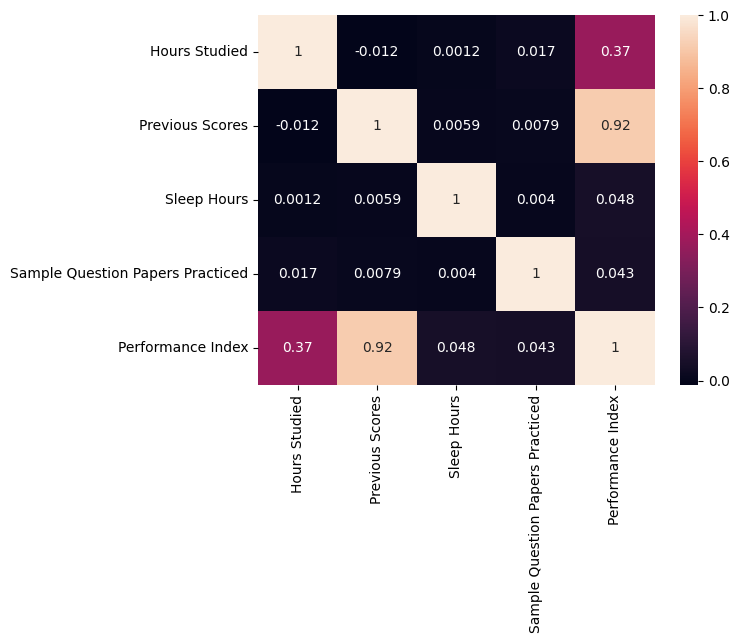

In [22]:
sns.heatmap(SP.drop("Extracurricular Activities",axis=1).corr(), annot=True)

#  Data Preprocessing


In [24]:
# Let's check the missing values.
missing_values = SP.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


The Extracurricular Activities column is categorical. We should convert it to numerical before inputting it into the model.

We will use LabelEncoder from sklearn, which should give each category a unique number.


In [26]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the City/Town column
SP['Extracurricular Activities'] = label_encoder.fit_transform(SP['Extracurricular Activities'])
SP

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,1,4,2,23.0
9996,7,64,1,8,5,58.0
9997,6,83,1,8,5,74.0
9998,9,97,1,7,0,95.0


We will use MinMaxScaler from sklearn, which would convert the values to range [0,1]

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# We want to scale all the columns, BUT NOT THE TARGET
cols = SP.columns.drop("Performance Index")

SP[cols] = scaler.fit_transform(SP[cols])
SP

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,0.750,1.000000,1.0,1.0,0.111111,91.0
1,0.375,0.711864,0.0,0.0,0.222222,65.0
2,0.875,0.186441,1.0,0.6,0.222222,45.0
3,0.500,0.203390,1.0,0.2,0.222222,36.0
4,0.750,0.593220,0.0,0.8,0.555556,66.0
...,...,...,...,...,...,...
9995,0.000,0.152542,1.0,0.0,0.222222,23.0
9996,0.750,0.406780,1.0,0.8,0.555556,58.0
9997,0.625,0.728814,1.0,0.8,0.555556,74.0
9998,1.000,0.966102,1.0,0.6,0.000000,95.0


# Linear Regression (By NumPy)

In [41]:
# Extract features (X) and target (y)
X = SP.drop("Performance Index",axis=1)
y = SP['Performance Index']

In [54]:
# Add a bias (intercept) term to X
X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Add a column of ones

# Compute the weights using the normal equation
weights = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

# The "@" operator is used for matrix multiplication in Python, specifically for NumPy arrays.
# An alternative method to perform matrix multiplication is using the np.dot() function, like this: np.dot(A, w).

# Make predictions
y_pred = X_b @ weights # calculate predictions using our optimized coefficient params and bias


# Evaluate the model (Mean Squared Error)
mse = np.mean((y - y_pred) ** 2)

print("Weights (Intercept and Coefficients):", weights)
print("Mean Squared Error:", mse)


Weights (Intercept and Coefficients): [11.43700067 22.82385643 60.08761735  0.61289758  2.40279877  1.74421926]
Mean Squared Error: 4.151350633946037


The model predicts the values of y for the same input data X that was used to train the model.
This process helps evaluate how well the model fits the training data.
However, it does not test generalization (i.e., how well the model performs on unseen data).

To evaluate the model's performance properly, you should split the data into training and testing sets:

* Training Set: Used to train (fit) the model.
* Testing Set: Used to evaluate the model's predictions on unseen data.

In [55]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Add a bias term to the training and testing sets
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Step 3: Compute the weights using the training set
weights = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

# Step 4: Make predictions on the testing set
y_pred = X_test_b @ weights

# Step 5: Evaluate the model on the testing set (Mean Squared Error)
mse_test = np.mean((y_test - y_pred) ** 2)

print("Weights (Intercept and Coefficients):", weights)
print("Mean Squared Error on Testing Set:", mse_test)

Weights (Intercept and Coefficients): [11.51783161 22.81987144 60.00230374  0.60861668  2.38470742  1.72648297]
Mean Squared Error on Testing Set: 4.082628398521862


The difference in Mean Squared Error (MSE) between the model trained on all data and the one evaluated on the test set after splitting is relatively small, which is a good sign.

#  Regression Models (By sklearn)
We will need to first split up our data into an X array that contains the features to train on, and a y array with the target variable, in this case, the Performance Index column.

In [40]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10, positive=True, max_iter=10000),  # Linear Model (Regularized)
    "LASSO Regression": Lasso(alpha=100, positive=True, max_iter=10000), # Linear Model (Regularized)
}


for model_name, model in models.items():
    scores_mae = []
    scores_rmse = []

    # 5-Fold cross-validation
    for train_index, test_index in KFold(n_splits=5).split(X, y):
        # Split data into training and testing sets
        X_Train, X_Test = X.loc[train_index,:], X.loc[test_index,:]
        y_Train, y_Test = y[train_index], y[test_index]
        # Train the model
        model.fit(X_Train, y_Train)
        # Predict on the test set
        y_pred = model.predict(X_Test)
        # Calculate metrics
        scores_mae.append(mean_absolute_error(y_Test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_Test, y_pred)))
    # Print the results

    print(f"{model_name} MAE Score: {np.mean(scores_mae)}")
    print(f"{model_name} RMSE Score: {np.mean(scores_rmse)}\n")

Linear Regression MAE Score: 1.618172826356438
Linear Regression RMSE Score: 2.038224299294236

Ridge Regression MAE Score: 1.6313285830075581
Ridge Regression RMSE Score: 2.0556493441201384

LASSO Regression MAE Score: 16.20390975
LASSO Regression RMSE Score: 19.21051609558412



### Model Comparison and Insights

- Both models perform similarly, with Linear Regression slightly outperforming Ridge Regression. Ridge Regression introduces L2 regularization, which can help in cases of multicollinearity or overfitting, but here it doesn't provide a significant advantage, indicating that the dataset is well-suited for a standard Linear Regression approach.

- The performance of LASSO Regression is significantly worse, as shown by the much higher MAE and RMSE scores. LASSO’s L1 regularization might have overly reduced important feature coefficients, leading to poor predictions. This suggests that the dataset may not benefit from the aggressive feature selection imposed by LASSO.


*  The important features

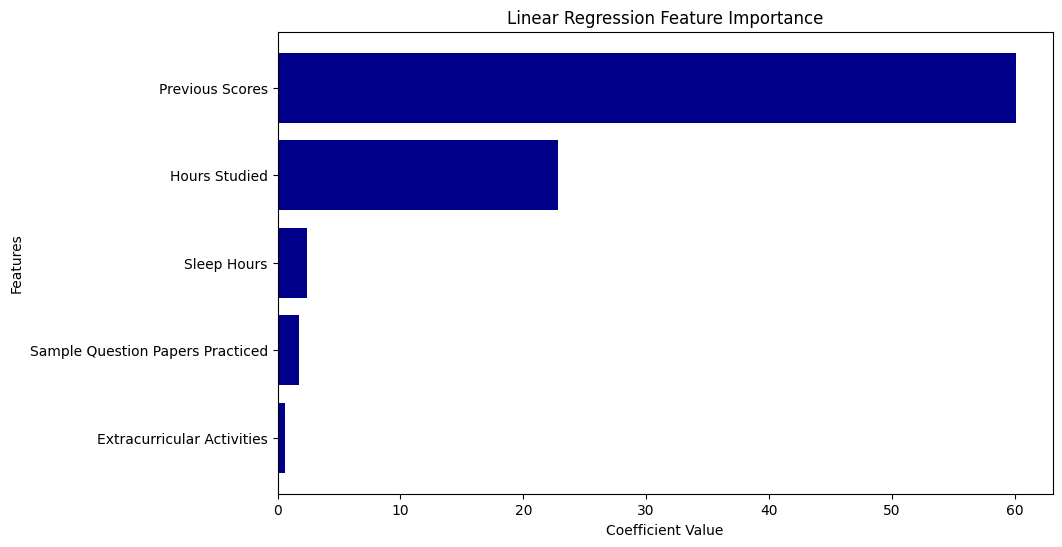

In [94]:
# Retrieve Linear coefficients and sort by absolute importance
linear_model = models["Linear Regression"]
linear_importance = list(zip(X.columns, linear_model.coef_))
sorted_linear_importance= sorted(linear_importance, key=lambda x: abs(x[1]), reverse=True)

# Extract sorted features and their coefficients
features, coefficients = zip(*sorted_linear_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='darkblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Linear Regression Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

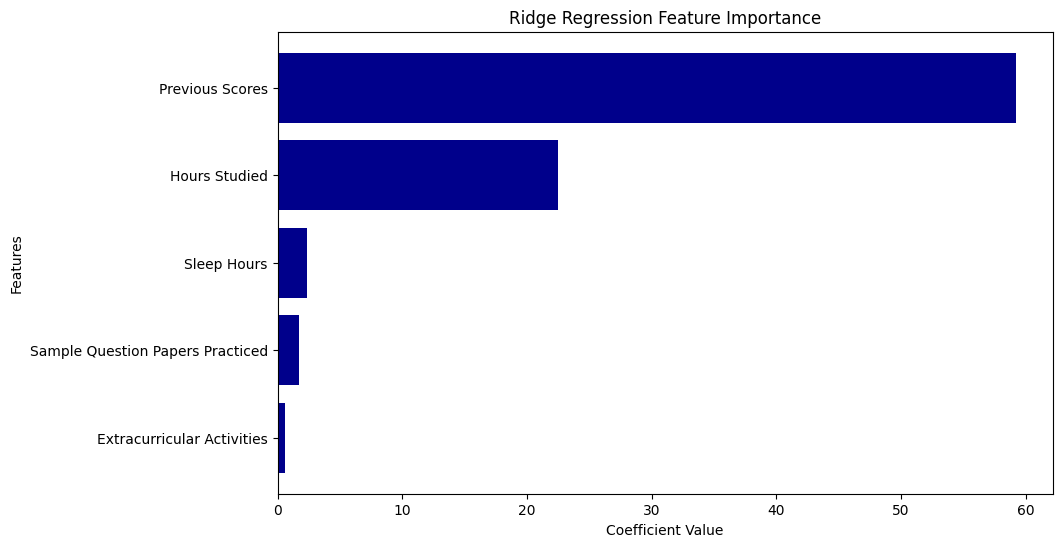

In [92]:
# Retrieve Ridge coefficients and sort by absolute importance
ridge_model = models["Ridge Regression"]
ridge_importance = list(zip(X.columns, ridge_model.coef_))
sorted_ridge_importance = sorted(ridge_importance, key=lambda x: abs(x[1]), reverse=True)

# Extract sorted features and their coefficients
features, coefficients = zip(*sorted_ridge_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='darkblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Ridge Regression Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

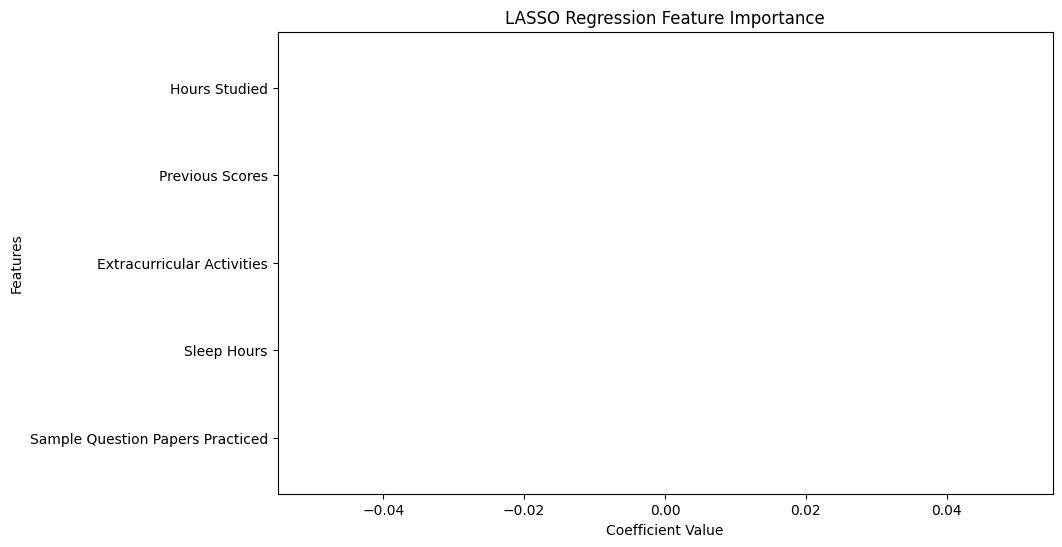

In [93]:
# Retrieve LASSO coefficients and sort by absolute importance
lasso_model = models["LASSO Regression"]
lasso_importance = list(zip(X.columns, lasso_model.coef_))
sorted_lasso_importance = sorted(lasso_importance, key=lambda x: abs(x[1]), reverse=True)

# Extract features and their coefficients
features, coefficients = zip(*sorted_lasso_importance)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='darkred')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('LASSO Regression Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

# Linear Regression (By PyTorch)

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming SP is a DataFrame with features and target
X = SP.drop("Performance Index", axis=1)
y = SP["Performance Index"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to NumPy arrays and then to PyTorch tensors
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to (N, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the Linear Regression model
class LinearRegressionModel_NN(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel_NN, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # input_dim features, 1 output

    def forward(self, x):
        return self.linear(x)

# Initialize the model with the correct input dimension
input_dim = X_train_tensor.shape[1]  # Number of features
model = LinearRegressionModel_NN(input_dim)

# Define the loss function (Mean Squared Error) and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [76]:
# Training loop
num_epochs = 2000
train_losses = []

for epoch in range(num_epochs):
    # Forward pass: Compute predictions
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)  # Compute the loss

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 4.1719
Epoch [200/2000], Loss: 4.1715
Epoch [300/2000], Loss: 4.1712
Epoch [400/2000], Loss: 4.1709
Epoch [500/2000], Loss: 4.1707
Epoch [600/2000], Loss: 4.1706
Epoch [700/2000], Loss: 4.1704
Epoch [800/2000], Loss: 4.1703
Epoch [900/2000], Loss: 4.1702
Epoch [1000/2000], Loss: 4.1701
Epoch [1100/2000], Loss: 4.1701
Epoch [1200/2000], Loss: 4.1700
Epoch [1300/2000], Loss: 4.1700
Epoch [1400/2000], Loss: 4.1699
Epoch [1500/2000], Loss: 4.1699
Epoch [1600/2000], Loss: 4.1699
Epoch [1700/2000], Loss: 4.1698
Epoch [1800/2000], Loss: 4.1698
Epoch [1900/2000], Loss: 4.1698
Epoch [2000/2000], Loss: 4.1698


In [77]:
# Evaluate the model on the testing set
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    mse_test = criterion(y_test_pred, y_test_tensor).item()

print(f"Mean Squared Error on Testing Set: {mse_test:.4f}")

# Print weights and bias
weights = model.linear.weight.data.numpy()
bias = model.linear.bias.data.numpy()
print(f"Weights: {weights}, Bias: {bias}")

# Predicted values for the testing set
print("Predicted values on Testing Set:", y_test_pred.numpy())

Mean Squared Error on Testing Set: 4.0845
Weights: [[22.809439  59.9864     0.6055162  2.3755322  1.7154167]], Bias: [11.544086]
Predicted values on Testing Set: [[54.715275]
 [22.62591 ]
 [47.902508]
 ...
 [16.807306]
 [63.34368 ]
 [45.946014]]


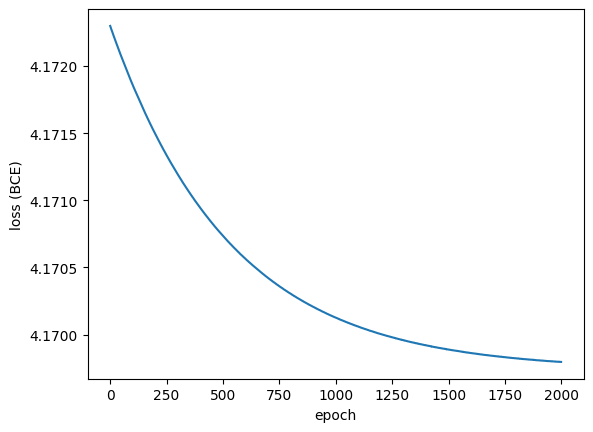

In [86]:
plt.plot(train_losses)

plt.xlabel('epoch')
plt.ylabel('loss (BCE)')

plt.show()